In [89]:
import pandas as pd

import numpy as np
from wandb.apis.public import Run
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from adjustText import adjust_text


In [90]:
api = wandb.Api()

In [106]:
def get_history(run: Run, selected_keys = {"precision", "f5_score", "recall", "f1_score", "val_total_loss", "avg_scores", "avg_dscores", "train_loss", }) -> pd.DataFrame:
    print(f"Run: {run.name}")
    # print(f"Config: {run.config}")
    history = run.scan_history()

      # Convert to set
    df = pd.DataFrame([row for row in history if selected_keys & row.keys()])  # Set intersection



    # Assuming your data is in a DataFrame called 'df'
    def compact_epochs(df):
        # Group by epoch and aggregate, taking the first non-NaN value for each column
        return df.groupby('epoch').agg(lambda x: x.dropna().iloc[0] if not x.dropna().empty else np.nan).reset_index()

    compacted_df = compact_epochs(df)
    return compacted_df

def get_best_epoch(df: pd.DataFrame, metric: str = "f1_score") -> pd.Series:
    if metric not in df.columns:
        raise ValueError(f"Metric '{metric}' not found in DataFrame columns.")

    best_epoch_row = df.loc[df[metric].idxmax()]
    return best_epoch_row


def plot_metric_over_epochs(df, main_metric="f1_score", aux_metrics=None, figsize=(12, 7),
                            style="whitegrid", palette="husl", show_best=True, smooth=False,
                            title_suffix=None):
    """
    Create a beautiful plot of metrics over epochs using seaborn.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing 'epoch' column and the specified metrics
    main_metric : str
        Name of the primary metric column to plot (highlighted)
    aux_metrics : list or None
        List of auxiliary metric names to plot with reduced alpha
    figsize : tuple
        Figure size (width, height)
    style : str
        Seaborn style ('whitegrid', 'darkgrid', 'white', 'dark', 'ticks')
    palette : str
        Color palette name
    show_best : bool
        Whether to highlight the best value for main metric
    smooth : bool
        Whether to add a smoothed trend line for main metric
    title_suffix : str or None
        Custom title suffix. Use {main_metric} as placeholder for metric name.
        Default: "{main_metric} Over Training Epochs"
    """

    # Validate main metric
    if main_metric not in df.columns:
        raise ValueError(f"Main metric '{main_metric}' not found in DataFrame columns: {list(df.columns)}")

    # Validate auxiliary metrics
    if aux_metrics:
        missing_aux = [m for m in aux_metrics if m not in df.columns]
        if missing_aux:
            raise ValueError(f"Auxiliary metrics not found: {missing_aux}")

    # Set the aesthetic style
    sns.set_style(style)

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Get colors from palette - need more colors if we have aux metrics
    n_colors = 1 + len(aux_metrics or []) + 2  # main + aux + trend + best
    colors = sns.color_palette(palette, n_colors)

    # Plot auxiliary metrics first (so main metric is on top)
    if aux_metrics:
        for i, aux_metric in enumerate(aux_metrics):
            sns.lineplot(data=df, x='epoch', y=aux_metric,
                         marker='o', markersize=4, linewidth=1.5, alpha=0.4,
                         color=colors[i + 3], label=aux_metric.replace('_', ' ').title(),
                         ax=ax)

    # Main metric plot with enhanced styling
    main_line = sns.lineplot(data=df, x='epoch', y=main_metric,
                             marker='o', markersize=8, linewidth=3,
                             color=colors[0], alpha=0.9,
                             label=f"{main_metric.replace('_', ' ').title()} (Main)",
                             ax=ax)

    # Add smooth trend line if requested (only for main metric)
    if smooth and len(df) > 3:
        sns.regplot(data=df, x='epoch', y=main_metric,
                    scatter=False, ax=ax, color=colors[1],
                    line_kws={'alpha': 0.6, 'linestyle': '--', 'linewidth': 2},
                    label='Trend')

    # Highlight the best value (only for main metric)
    if show_best:
        best_idx = df[main_metric].idxmax()
        best_epoch = df.loc[best_idx, 'epoch']
        best_value = df.loc[best_idx, main_metric]

        ax.scatter(best_epoch, best_value, color=colors[2], s=150,
                   zorder=5, edgecolor='white', linewidth=2,
                   label='Best Value')

        # Smart annotation positioning to avoid overlaps
        y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
        x_range = ax.get_xlim()[1] - ax.get_xlim()[0]

        # Position annotation based on where best point is
        if best_epoch > (ax.get_xlim()[0] + x_range * 0.7):  # Right side
            xytext = (-15, 15)
        else:  # Left side
            xytext = (15, 15)

        ax.annotate(f'Best: {best_value:.4f}\nEpoch: {int(best_epoch)}',
                    xy=(best_epoch, best_value),
                    xytext=xytext, textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', fc=colors[2], alpha=0.8),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1'),
                    fontsize=10, fontweight='bold', color='white')

    # Enhanced title with template support
    main_metric_title = main_metric.replace('_', ' ').title()
    if title_suffix:
        title = title_suffix.format(main_metric=main_metric_title)
    else:
        title = f'{main_metric_title} Over Training Epochs'

    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
    ax.set_ylabel('Metric Value', fontsize=14, fontweight='bold')

    # Customize grid and spines
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)

    # Add subtle background
    ax.set_facecolor('#fafafa')

    # Improve tick styling
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Add summary statistics for main metric
    stats_text = (f'{main_metric_title}:\n'
                  f'Max: {df[main_metric].max():.4f}\n'
                  f'Min: {df[main_metric].min():.4f}\n'
                  f'Final: {df[main_metric].iloc[-1]:.4f}')

    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))

    # Add legend if we have multiple metrics
    if aux_metrics or smooth or show_best:
        legend = ax.legend(loc='lower center', frameon=True, fancybox=True,
                           shadow=True, fontsize=10)
        # Make legend background semi-transparent
        legend.get_frame().set_alpha(0.9)

    plt.tight_layout()
    plt.show()

## SNS version of plot_runs with adjustText for better annotation placement


In [92]:
# import matplotlib.pyplot as plt
# import seaborn as sns
#
# def plot_runs(data_dict, x_col, y_col, best_values_dict=None, figsize=(12, 6),
#               title=None, xlabel=None, ylabel=None, style="whitegrid", palette="husl"):
#     """
#     Plot multiple runs from a dictionary of dataframes using seaborn styling.
#
#     Parameters:
#     -----------
#     data_dict : dict
#         Dictionary with run names as keys and dataframes as values
#     x_col : str
#         Column name for x-axis
#     y_col : str
#         Column name for y-axis
#     best_values_dict : dict, optional
#         Dictionary with run names as keys and dict of best values as values
#         e.g., {'run1': {'best_epoch': 15, 'best_f1_score': 0.863}}
#     figsize : tuple
#         Figure size (width, height)
#     title : str, optional
#         Plot title
#     xlabel : str, optional
#         X-axis label (defaults to x_col if not provided)
#     ylabel : str, optional
#         Y-axis label (defaults to y_col if not provided)
#     style : str
#         Seaborn style ('whitegrid', 'darkgrid', 'white', 'dark', 'ticks')
#     palette : str
#         Color palette name
#     """
#     # Set seaborn style
#     sns.set_style(style)
#
#     fig, ax = plt.subplots(figsize=figsize)
#
#     # Get colors from palette
#     n_runs = len(data_dict)
#     colors = sns.color_palette(palette, n_runs)
#
#     # Plot each run
#     for idx, (run_name, df) in enumerate(data_dict.items()):
#         # Create label with best value if available
#         label = run_name
#         if best_values_dict and run_name in best_values_dict:
#             best_info = best_values_dict[run_name]
#             best_y_key = f'best_{y_col}'
#             if best_y_key in best_info:
#                 best_value = best_info[best_y_key]
#                 label = f'{run_name} (best: {best_value:.4f})'
#
#         # Use seaborn lineplot
#         sns.lineplot(data=df, x=x_col, y=y_col,
#                     marker='o', markersize=6, linewidth=2,
#                     color=colors[idx], alpha=0.8,
#                     label=label, ax=ax)
#
#         # Add vertical line and marker for best value if provided
#         if best_values_dict and run_name in best_values_dict:
#             best_info = best_values_dict[run_name]
#             best_x_key = f'best_{x_col}'
#             best_y_key = f'best_{y_col}'
#
#             if best_x_key in best_info and best_y_key in best_info:
#                 best_x = best_info[best_x_key]
#                 best_y = best_info[best_y_key]
#
#                 # Add vertical line
#                 ax.axvline(x=best_x, linestyle='--', alpha=0.4,
#                           linewidth=1.5, color=colors[idx])
#
#                 # Mark the best point explicitly with a larger marker
#                 ax.scatter([best_x], [best_y], s=200, zorder=5,
#                           color=colors[idx], edgecolors='white', linewidths=3,
#                           marker='*')  # Star marker for best value
#
#     # Set labels and title
#     ax.set_xlabel(xlabel or x_col.replace('_', ' ').title(),
#                  fontsize=14, fontweight='bold')
#     ax.set_ylabel(ylabel or y_col.replace('_', ' ').title(),
#                  fontsize=14, fontweight='bold')
#     ax.set_title(title or f'{y_col.replace("_", " ").title()} vs {x_col.replace("_", " ").title()}',
#                 fontsize=16, fontweight='bold', pad=20)
#
#     # Set y-axis limit
#     ax.set_ylim(top=1.0)
#
#     # Customize grid and spines
#     ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_linewidth(0.5)
#     ax.spines['bottom'].set_linewidth(0.5)
#
#     # Add subtle background
#     ax.set_facecolor('#fafafa')
#
#     # Improve tick styling
#     ax.tick_params(axis='both', which='major', labelsize=12)
#
#     # Legend styling with best values
#     legend = ax.legend(loc='best', frameon=True, fancybox=True,
#                       shadow=True, fontsize=10)
#     legend.get_frame().set_alpha(0.9)
#
#     plt.tight_layout()
#     return fig, ax

In [108]:
from loguru import logger
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_runs(data_dict, x_col, y_col, best_values_dict=None, figsize=(12, 6),
              title=None, xlabel=None, ylabel=None,
                y_min_limit=0, y_max_limit=1.0,
              style="whitegrid", palette="husl", filename=None,
              smooth=True, smooth_window=5, smooth_method='rolling',):
    """
    Plot multiple runs from a dictionary of dataframes using seaborn styling.

    Parameters:
    -----------
    data_dict : dict
        Dictionary with run names as keys and dataframes as values
    x_col : str
        Column name for x-axis
    y_col : str
        Column name for y-axis
    best_values_dict : dict, optional
        Dictionary with run names as keys and dict of best values as values
        e.g., {'run1': {'best_epoch': 15, 'best_f1_score': 0.863}}
    figsize : tuple
        Figure size (width, height)
    title : str, optional
        Plot title
    xlabel : str, optional
        X-axis label (defaults to x_col if not provided)
    ylabel : str, optional
        Y-axis label (defaults to y_col if not provided)
    style : str
        Seaborn style ('whitegrid', 'darkgrid', 'white', 'dark', 'ticks')
    palette : str
        Color palette name
    smooth : bool
        Whether to apply smoothing to the lines
    smooth_window : int
        Window size for smoothing (higher = smoother)
    smooth_method : str
        Smoothing method: 'rolling' (moving average), 'ewm' (exponential), or 'savgol' (Savitzky-Golay)
    """
    # Set seaborn style
    sns.set_style(style)

    fig, ax = plt.subplots(figsize=figsize)

    # Get colors from palette
    n_runs = len(data_dict)
    colors = sns.color_palette(palette, n_runs)

    # Plot each run
    for idx, (run_name, df) in enumerate(data_dict.items()):
        # Create label with best value if available
        label = run_name
        if best_values_dict and run_name in best_values_dict:
            best_info = best_values_dict[run_name]
            best_y_key = f'best_{y_col}'
            if best_y_key in best_info:
                best_value = best_info[best_y_key]
                label = f'{run_name} (best: {best_value:.4f})'

        # Prepare data for plotting
        plot_df = df.copy()

        # Apply smoothing if requested
        if smooth:
            if smooth_method == 'rolling':
                # Simple moving average
                plot_df[f'{y_col}_smooth'] = plot_df[y_col].rolling(
                    window=smooth_window, center=True, min_periods=1
                ).mean()
            elif smooth_method == 'ewm':
                # Exponential weighted moving average
                plot_df[f'{y_col}_smooth'] = plot_df[y_col].ewm(
                    span=smooth_window, adjust=False
                ).mean()
            elif smooth_method == 'savgol':
                # Savitzky-Golay filter (requires scipy)
                from scipy.signal import savgol_filter
                window = min(smooth_window, len(plot_df))
                if window % 2 == 0:
                    window += 1  # Must be odd
                if window >= 3:
                    plot_df[f'{y_col}_smooth'] = savgol_filter(
                        plot_df[y_col], window_length=window, polyorder=2
                    )
                else:
                    plot_df[f'{y_col}_smooth'] = plot_df[y_col]

            y_plot_col = f'{y_col}_smooth'

            # Plot original data with transparency
            ax.plot(plot_df[x_col], plot_df[y_col],
                   alpha=0.2, linewidth=1, color=colors[idx])
        else:
            y_plot_col = y_col

        # Plot smoothed line
        sns.lineplot(data=plot_df, x=x_col, y=y_plot_col,
                    marker='o', markersize=3,
                    linewidth=2,
                    color=colors[idx], alpha=0.8,
                    label=label, ax=ax,
                    estimator=None,
                    errorbar=None)

        # Add vertical line and marker for best value if provided
        if best_values_dict and run_name in best_values_dict:
            best_info = best_values_dict[run_name]
            best_x_key = f'best_{x_col}'
            best_y_key = f'best_{y_col}'

            if best_x_key in best_info and best_y_key in best_info:
                best_x = best_info[best_x_key]
                best_y = best_info[best_y_key]

                # Add vertical line
                ax.axvline(x=best_x, linestyle='--', alpha=0.4,
                          linewidth=1.5, color=colors[idx])

                # Mark the best point explicitly with a star
                ax.scatter([best_x], [best_y], s=450, zorder=5,
                          color=colors[idx], edgecolors='white', linewidths=2,
                          marker='*')

    # Set labels and title
    ax.set_xlabel(xlabel or x_col.replace('_', ' ').title(),
                 fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel or y_col.replace('_', ' ').title(),
                 fontsize=14, fontweight='bold')
    if title:
        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)

    # Set y-axis limit
    ax.set_ylim(top=y_max_limit)
    ax.set_ylim(bottom=y_min_limit)

    # Customize grid and spines
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)

    # Add subtle background
    ax.set_facecolor('#fafafa')

    # Improve tick styling
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Legend styling with best values
    legend = ax.legend(loc='best', frameon=True, fancybox=True,
                      shadow=True, fontsize=10)
    legend.get_frame().set_alpha(0.9)

    plt.tight_layout()

    if filename:
        logger.info(f"Saving plot to {filename}")
        plt.savefig(filename, dpi=300)

    return fig, ax

In [129]:
from loguru import logger
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


def plot_runs_dual_metric(data_dict, x_col, y_col, y_col_2, best_values_dict=None, figsize=(12, 6),
                          title=None, xlabel=None, ylabel=None, ylabel_2=None,
                          y_min_limit=0, y_max_limit=None,
                          style="whitegrid", palette="husl", filename=None,
                          smooth=True, smooth_window=5, smooth_method='rolling',
                          linestyle_2='--'):
    """
    Plot multiple runs with two metrics from a dictionary of dataframes using seaborn styling.
    """
    # Set seaborn style
    sns.set_style(style)

    fig, ax = plt.subplots(figsize=figsize)

    # Get colors from palette
    n_runs = len(data_dict)
    colors = sns.color_palette(palette, n_runs)

    def apply_smoothing(df, col, smooth_method, smooth_window):
        """Helper function to apply smoothing"""
        if smooth_method == 'rolling':
            return df[col].rolling(window=smooth_window, center=True, min_periods=1).mean()
        elif smooth_method == 'ewm':
            return df[col].ewm(span=smooth_window, adjust=False).mean()
        elif smooth_method == 'savgol':
            from scipy.signal import savgol_filter
            window = min(smooth_window, len(df))
            if window % 2 == 0:
                window += 1
            if window >= 3:
                return savgol_filter(df[col], window_length=window, polyorder=2)
            else:
                return df[col]
        return df[col]

    # Plot each run
    for idx, (run_name, df) in enumerate(data_dict.items()):
        plot_df = df.copy()

        # Process first metric (y_col)
        label_1 = f'{run_name} - {y_col}'
        if best_values_dict and run_name in best_values_dict:
            best_info = best_values_dict[run_name]
            best_y_key = f'best_{y_col}'
            if best_y_key in best_info:
                best_value = best_info[best_y_key]
                label_1 = f'{run_name} - {y_col} (best: {best_value:.4f})'

        if smooth:
            plot_df[f'{y_col}_smooth'] = apply_smoothing(plot_df, y_col, smooth_method, smooth_window)
            y_plot_col = f'{y_col}_smooth'
            # Plot original data with transparency
            ax.plot(plot_df[x_col], plot_df[y_col],
                   alpha=0.15, linewidth=0.8, color=colors[idx])
        else:
            y_plot_col = y_col

        # Plot first metric (solid line, no markers)
        ax.plot(plot_df[x_col], plot_df[y_plot_col],
                linewidth=2.5,
                color=colors[idx], alpha=0.9,
                label=label_1,
                linestyle='-')

        # Process second metric (y_col_2)
        label_2 = f'{run_name} - {y_col_2}'
        if best_values_dict and run_name in best_values_dict:
            best_info = best_values_dict[run_name]
            best_y_key_2 = f'best_{y_col_2}'
            if best_y_key_2 in best_info:
                best_value_2 = best_info[best_y_key_2]
                label_2 = f'{run_name} - {y_col_2} (best: {best_value_2:.4f})'

        if smooth:
            plot_df[f'{y_col_2}_smooth'] = apply_smoothing(plot_df, y_col_2, smooth_method, smooth_window)
            y_plot_col_2 = f'{y_col_2}_smooth'
            # Plot original data with transparency
            ax.plot(plot_df[x_col], plot_df[y_col_2],
                   alpha=0.15, linewidth=0.8, color=colors[idx], linestyle=linestyle_2)
        else:
            y_plot_col_2 = y_col_2

        # Plot second metric (dashed line, no markers)
        ax.plot(plot_df[x_col], plot_df[y_plot_col_2],
                linewidth=2.5, linestyle=linestyle_2,
                color=colors[idx], alpha=0.9,
                label=label_2)

        # Add vertical line and markers for best values if provided
        if best_values_dict and run_name in best_values_dict:
            best_info = best_values_dict[run_name]

            # Mark best value for first metric
            best_x_key = f'best_{x_col}_{y_col}'
            best_y_key = f'best_{y_col}'
            if best_x_key in best_info and best_y_key in best_info:
                best_x = best_info[best_x_key]
                best_y = best_info[best_y_key]

                ax.axvline(x=best_x, linestyle='--', alpha=0.3,
                          linewidth=1.5, color=colors[idx])
                ax.scatter([best_x], [best_y], s=200, zorder=5,
                          color=colors[idx], edgecolors='white', linewidths=2,
                          marker='*')

            # Mark best value for second metric
            best_x_key_2 = f'best_{x_col}_{y_col_2}'
            best_y_key_2 = f'best_{y_col_2}'
            if best_x_key_2 in best_info and best_y_key_2 in best_info:
                best_x_2 = best_info[best_x_key_2]
                best_y_2 = best_info[best_y_key_2]

                ax.axvline(x=best_x_2, linestyle=':', alpha=0.3,
                          linewidth=1.5, color=colors[idx])
                ax.scatter([best_x_2], [best_y_2], s=200, zorder=5,
                          color=colors[idx], edgecolors='white', linewidths=2,
                          marker='D')

    # Set labels and title
    ax.set_xlabel(xlabel or x_col.replace('_', ' ').title(),
                 fontsize=14, fontweight='bold')

    # Combine y labels if both metrics are similar (e.g., both losses)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
    else:
        y_label_1 = y_col.replace('_', ' ').title()
        y_label_2 = y_col_2.replace('_', ' ').title()
        ax.set_ylabel(f'{y_label_1} / {y_label_2}', fontsize=14, fontweight='bold')

    if title:
        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)

    # Set y-axis limits
    if y_max_limit is not None:
        ax.set_ylim(top=y_max_limit)
    ax.set_ylim(bottom=y_min_limit)

    # Customize grid and spines
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)

    # Add subtle background
    ax.set_facecolor('#fafafa')

    # Improve tick styling
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Legend styling with best values
    legend = ax.legend(loc='best', frameon=True, fancybox=True,
                      shadow=True, fontsize=9, ncol=1)
    legend.get_frame().set_alpha(0.9)

    plt.tight_layout()

    if filename:
        logger.info(f"Saving plot to {filename}")
        plt.savefig(filename, dpi=300)

    return fig, ax





def get_best_values_dual(df, x_col, y_col, y_col_2, minimize=True):
    """
    Find the best (minimum or maximum) values for two metrics independently.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing the data
    x_col : str
        Column name for x-axis (e.g., 'epoch')
    y_col : str
        Column name for first y-axis metric (e.g., 'val_total_loss')
    y_col_2 : str
        Column name for second y-axis metric (e.g., 'train_loss')
    minimize : bool
        If True, find minimum (for losses). If False, find maximum (for metrics like F1)

    Returns:
    --------
    dict
        Dictionary with best values for both metrics, each with their own best x value
    """
    # Find best for first metric
    if minimize:
        best_idx_1 = df[y_col].idxmin()
        best_idx_2 = df[y_col_2].idxmin()
    else:
        best_idx_1 = df[y_col].idxmax()
        best_idx_2 = df[y_col_2].idxmax()

    best_row_1 = df.loc[best_idx_1]
    best_row_2 = df.loc[best_idx_2]

    result = {
        f'best_{x_col}_{y_col}': best_row_1[x_col],      # Best epoch for first metric
        f'best_{y_col}': best_row_1[y_col],               # Best value of first metric
        f'best_{x_col}_{y_col_2}': best_row_2[x_col],    # Best epoch for second metric
        f'best_{y_col_2}': best_row_2[y_col_2]            # Best value of second metric
    }

    return result

2025-10-23 20:03:39.134 | INFO     | __main__:plot_runs:160 - Saving plot to model_size_comparison_f1_score.png


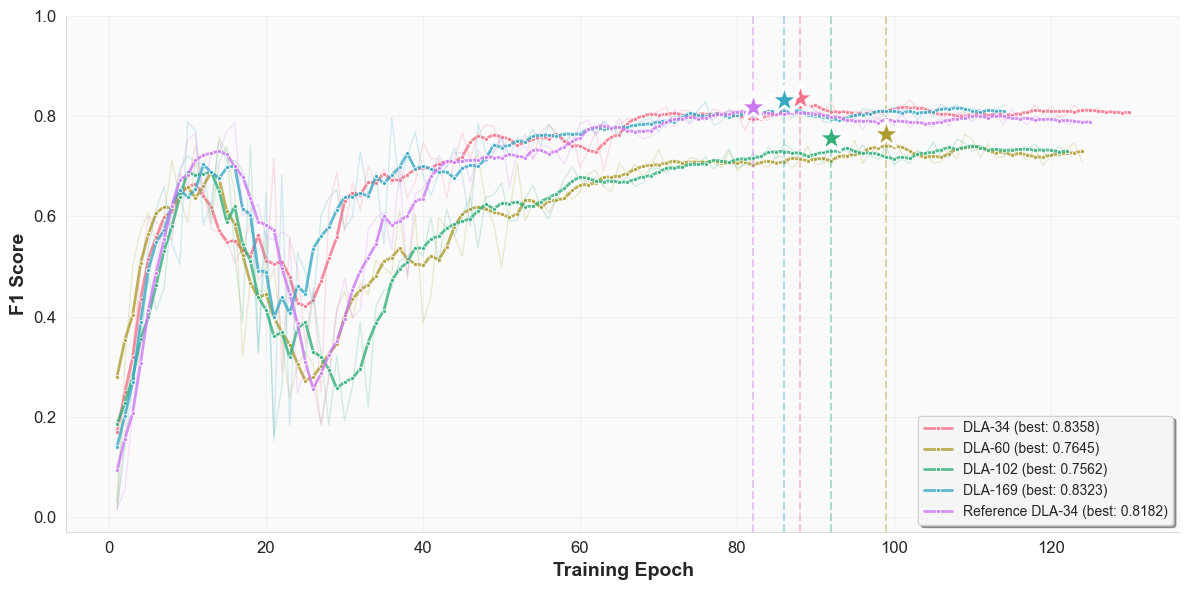

In [94]:
fig, ax = plot_runs(runs_data, x_col='epoch', y_col='f1_score',
                    best_values_dict=best_values,
                    # title='F1 Score across Training Epochs',
                    xlabel='Training Epoch',
                    ylabel='F1 Score',
                    filename="model_size_comparison_f1_score.png")
plt.show()


In [95]:
# run_1 = api.run("karisu/x13_model_size/win7v2oj")
# df_history_1 = get_history(run_1)
# summary_1 = run_1.summary
#
# run_2 = api.run("karisu/x13_model_size/runs/euiur991")
# df_history_2 = get_history(run_2)
# summary_2 = run_2.summary
#
# run_3 = api.run("karisu/x13_model_size/m6y0ckzd")
# df_history_3 = get_history(run_3)
# summary_3 = run_3.summary



In [96]:
# # Example usage:
# runs_data = {
#     "run1": df_history_1,
#     "run2": df_history_2,
#     "run3": df_history_3
# }
#
# best_values = {
#     "run1": summary_1,
#     "run2": summary_2,
#     "run3": summary_3
# }
#
# # Basic plot
# # fig, ax = plot_runs(runs_data, x_col='epoch', y_col='f1_score')
# # plt.show()
#
# # With best values marked
# fig, ax = plot_runs(runs_data, x_col='epoch', y_col='f1_score',
#                     best_values_dict=best_values,
#                     title='F1 Score across Training Epochs',
#                     xlabel='Training Epoch',
#                     ylabel='F1 Score')
# plt.show()


## Compare different model sizes

### Fernandina

Run: 20251023_DLA-34 Fernandina_mrwqwgu4
Run: 20251023_reference DLA-34 Fernandina_4ljrlise
Run: 20251023_DLA-60 Fernandina_nad09zjb
Run: 20251023_DLA-102 Fernandina_n85pac4n
Run: 20251023_DLA-169 Fernandina_tu7yccg6


2025-10-23 20:04:28.509 | INFO     | __main__:plot_runs:160 - Saving plot to model_size_comparison_fernandina_s_f1_score.pdf


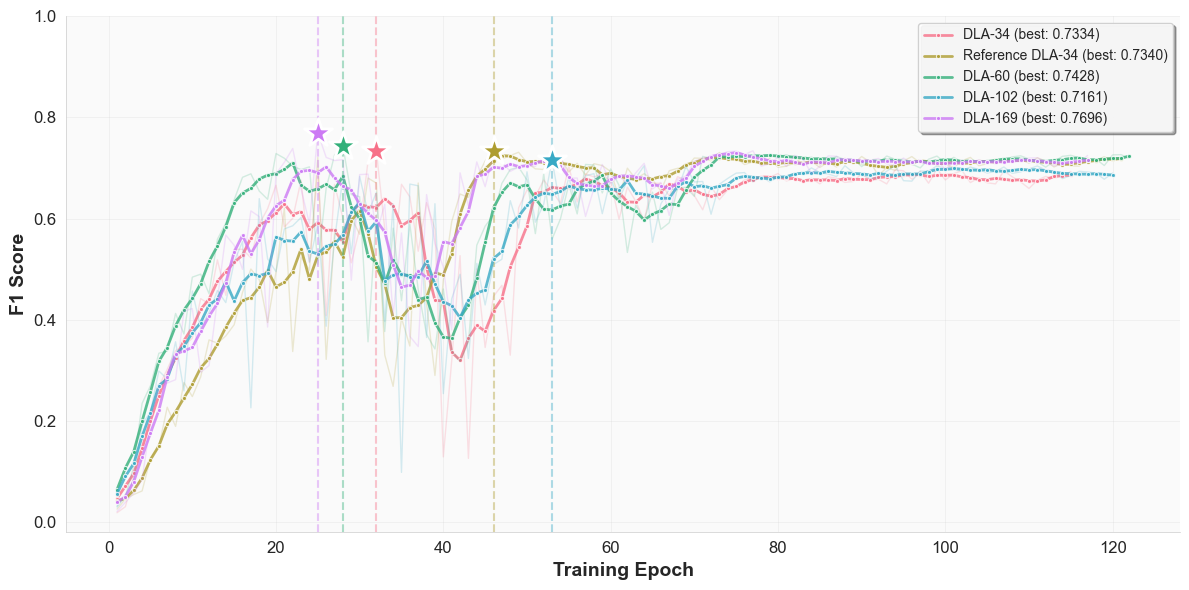

In [97]:
api = wandb.Api(timeout=300)

run_1 = api.run("karisu/x13_model_size/mrwqwgu4") # 20251023_DLA-34 Fernandina_mrwqwgu4
run_2 = api.run("karisu/x13_model_size/nad09zjb") # 20251023_DLA-60 Fernandina_nad09zjb
run_3 = api.run("karisu/x13_model_size/n85pac4n") # 20251023_DLA-102 Fernandina_n85pac4n
run_4 = api.run("karisu/x13_model_size/tu7yccg6") # 20251023_DLA-169 Fernandina_tu7yccg6

# run_5 = api.run("karisu/x13_model_size/m6y0ckzd") # DinoV2L Fernandina_m6y0ckzd
run_6 = api.run("karisu/x13_model_size/4ljrlise") # 20251023_reference DLA-34 Fernandina_4ljrlise

runs_data = {
    "DLA-34": get_history(run_1),
    "Reference DLA-34": get_history(run_6),
    "DLA-60": get_history(run_2),
    "DLA-102": get_history(run_3),
    "DLA-169": get_history(run_4),
    # "DinoV2-L": get_history(run_5),
}

best_values = {
    "DLA-34": run_1.summary,
    "Reference DLA-34": run_6.summary,
    "DLA-60": run_2.summary,
    "DLA-102": run_3.summary,
    "DLA-169": run_4.summary,
    # "DinoV2-L": run_5.summary,
}


# Basic plot
# fig, ax = plot_runs(runs_data, x_col='epoch', y_col='f1_score')
# plt.show()

# With best values marked
fig, ax = plot_runs(runs_data, x_col='epoch', y_col='f1_score',
                    best_values_dict=best_values,
                    # title='F1 Score across Training Epochs',
                    xlabel='Training Epoch',
                    ylabel='F1 Score',
                    filename="model_size_comparison_fernandina_s_f1_score.pdf")
plt.show()

Run: 20251023_DLA-34 Fernandina_nakgxiso
Run: 20251023_reference DLA-34 Fernandina_mw6upcfx
Run: 20251023_DLA-60 Fernandina_e707ivq5
Run: 20251023_DLA-102 Fernandina_8q1m2rdt
Run: 20251023_DLA-169 Fernandina_5lvueukh


2025-10-23 20:04:59.642 | INFO     | __main__:plot_runs:160 - Saving plot to model_size_comparison_fernandina_s_f1_score_double_check.pdf


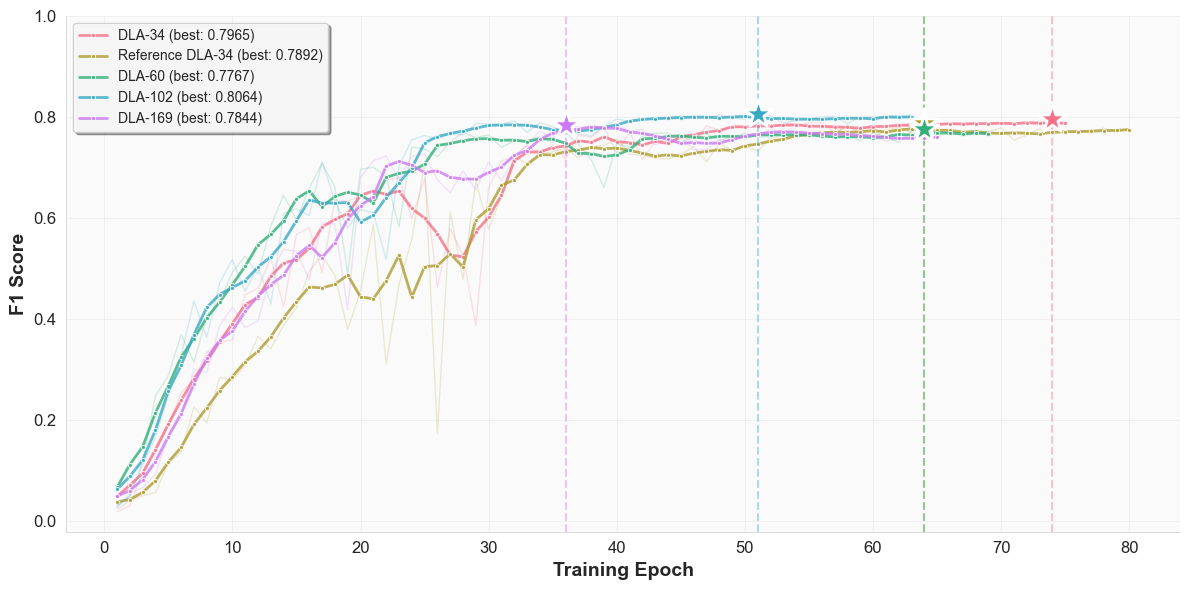

In [98]:
api = wandb.Api(timeout=300)

run_1 = api.run("karisu/x13_model_size/nakgxiso") # 20251023_DLA-34 Fernandina_nakgxiso
run_2 = api.run("karisu/x13_model_size/e707ivq5") # 20251023_DLA-60 Fernandina_e707ivq5


run_3 = api.run("karisu/x13_model_size/8q1m2rdt") # 20251023_DLA-102 Fernandina_8q1m2rdt
run_4 = api.run("karisu/x13_model_size/5lvueukh") # 20251023_DLA-169 Fernandina_5lvueukh


run_5 = api.run("karisu/x13_model_size/6vm7206r") # 20251023_x13_model_size_DinoV2L_fernandina_cvat_corr_dla34_pub_train_tile_eval_tile_aug_default_6vm7206r
run_6 = api.run("karisu/x13_model_size/mw6upcfx") # 20251023_reference DLA-34 Fernandina_mw6upcfx

runs_data = {
    "DLA-34": get_history(run_1),
    "Reference DLA-34": get_history(run_6),
    "DLA-60": get_history(run_2),
    "DLA-102": get_history(run_3),
    "DLA-169": get_history(run_4),
    # "DinoV2-L": get_history(run_5),
}

best_values = {
    "DLA-34": run_1.summary,
    "Reference DLA-34": run_6.summary,
    "DLA-60": run_2.summary,
    "DLA-102": run_3.summary,
    "DLA-169": run_4.summary,
    # "DinoV2-L": run_5.summary,
}


# Basic plot
# fig, ax = plot_runs(runs_data, x_col='epoch', y_col='f1_score')
# plt.show()

# With best values marked
fig, ax = plot_runs(runs_data, x_col='epoch', y_col='f1_score',
                    best_values_dict=best_values,
                    # title='F1 Score across Training Epochs',
                    xlabel='Training Epoch',
                    ylabel='F1 Score',
                    filename="model_size_comparison_fernandina_s_f1_score_double_check.pdf")
plt.show()

### Floreana

Run: 20251023_DLA-34 Floreana_6hs4sz8k
Run: 20251023_reference DLA-34 Floreana_w6ghkjdm
Run: 20251023_DLA60 Floreana_ej0j7ylm
Run: 20251023_DLA102 Floreana_9wbdancd
Run: 20251023_DLA-169 Floreana_xocilxs6


2025-10-23 20:06:35.381 | INFO     | __main__:plot_runs:160 - Saving plot to model_size_comparison_floreana_s_f1_score.pdf


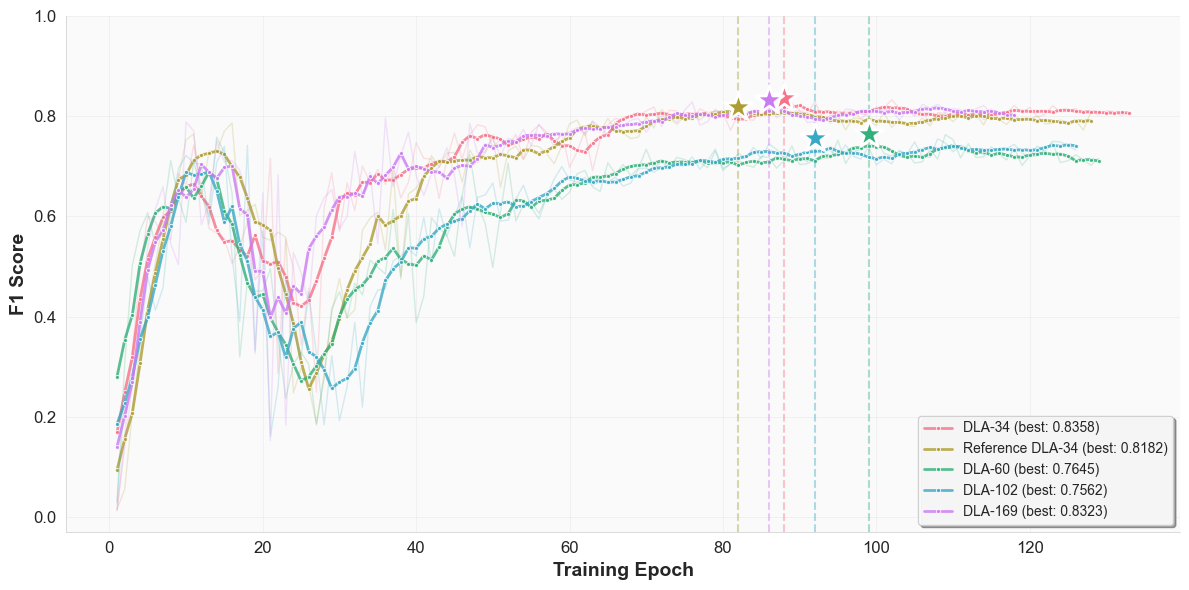

In [99]:
run_1 = api.run("karisu/x13_model_size/6hs4sz8k") # 20251023_DLA-34 Floreana_6hs4sz8k
run_2 = api.run("karisu/x13_model_size/ej0j7ylm") # 20251023_DLA60 Floreana_ej0j7ylm
run_3 = api.run("karisu/x13_model_size/9wbdancd") # 20251023_DLA102 Floreana_9wbdancd
run_4 = api.run("karisu/x13_model_size/xocilxs6") # 20251023_DLA-169 Floreana_xocilxs6
run_5 = api.run("karisu/x13_model_size/w6ghkjdm") # 20251023_reference DLA-34 Floreana_w6ghkjdm
# run_6 = api.run("karisu/x13_model_size/p2bzbm16") # 20251023_DinoV2L Floreana_p2bzbm16



runs_data = {
    "DLA-34": get_history(run_1),
    "Reference DLA-34": get_history(run_5),
    "DLA-60": get_history(run_2),
    "DLA-102": get_history(run_3),
    "DLA-169": get_history(run_4),
    # "DinoV2-L": get_history(run_6),
}

best_values = {
    "DLA-34": run_1.summary,
    "Reference DLA-34": run_5.summary,
    "DLA-60": run_2.summary,
    "DLA-102": run_3.summary,
    "DLA-169": run_4.summary,
    # "DinoV2-L": run_6.summary,
}

# With best values marked
fig, ax = plot_runs(runs_data, x_col='epoch', y_col='f1_score',
                    best_values_dict=best_values,
                    title=None,
                    # title='F1 Score across Training Epochs',
                    xlabel='Training Epoch',
                    ylabel='F1 Score',
                    filename="model_size_comparison_floreana_s_f1_score.pdf")
plt.show()


In [137]:
runs_data = {
    "DLA-34": get_history(run_1),
    "Reference DLA-34": get_history(run_5),
    "DLA-60": get_history(run_2),
    "DLA-102": get_history(run_3),
    "DLA-169": get_history(run_4),
    "DinoV2-L": get_history(run_6),
}

best_values = {
    "DLA-34": run_1.summary,
    "Reference DLA-34": run_5.summary,
    "DLA-60": run_2.summary,
    "DLA-102": run_3.summary,
    "DLA-169": run_4.summary,
    # "DinoV2-L": run_6.summary,
}



Run: 20251023_DLA-34 Floreana_6hs4sz8k
Run: 20251023_reference DLA-34 Floreana_w6ghkjdm
Run: 20251023_DLA60 Floreana_ej0j7ylm
Run: 20251023_DLA102 Floreana_9wbdancd
Run: 20251023_DLA-169 Floreana_xocilxs6
Run: 20251023_DinoV2L Floreana_p2bzbm16


In [138]:
def get_best_values(df, x_col="epoch", y_col="f1_score", ascending=True):
    """
    Find the best (maximum) value for a metric and its corresponding x value.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing the data
    x_col : str
        Column name for x-axis (e.g., 'epoch')
    y_col : str
        Column name for y-axis metric (e.g., 'f1_score')

    Returns:
    --------
    dict
        Dictionary with best values, e.g., {'best_epoch': 92, 'best_f1_score': 0.756}
    """
    # Find the row with maximum y value
    if ascending:
        best_idx = df[y_col].idxmin()
    else:
        best_idx = df[y_col].idxmax()
    best_row = df.loc[best_idx]

    return {
        f'best_{x_col}': best_row[x_col],
        f'best_{y_col}': best_row[y_col]
    }

best_values_dict = {run_name: get_best_values(df, y_col="f1_score", ascending=False) for run_name, df in runs_data.items()}
best_values_dict


{'DLA-34': {'best_epoch': 88.0, 'best_f1_score': 0.835820895522388},
 'Reference DLA-34': {'best_epoch': 143.0,
  'best_f1_score': 0.8202247191011235},
 'DLA-60': {'best_epoch': 99.0, 'best_f1_score': 0.7645429362880886},
 'DLA-102': {'best_epoch': 142.0, 'best_f1_score': 0.7675070028011205},
 'DLA-169': {'best_epoch': 86.0, 'best_f1_score': 0.8323353293413174},
 'DinoV2-L': {'best_epoch': 10.0, 'best_f1_score': 0.8791208791208791}}

In [120]:
# With best values marked
best_values_dict = {run_name: get_best_values(df, y_col="val_total_loss", ascending=True) for run_name, df in runs_data.items()}
best_values_dict



{'DLA-34': {'best_epoch': 7.0, 'best_val_total_loss': 1.8408445119857788},
 'Reference DLA-34': {'best_epoch': 8.0,
  'best_val_total_loss': 1.847633957862854},
 'DLA-60': {'best_epoch': 6.0, 'best_val_total_loss': 1.882378101348877},
 'DLA-102': {'best_epoch': 9.0, 'best_val_total_loss': 1.8498350381851196},
 'DLA-169': {'best_epoch': 29.0, 'best_val_total_loss': 1.7746726274490356}}

2025-10-23 20:40:39.435 | INFO     | __main__:plot_runs:162 - Saving plot to model_size_comparison_floreana_s_val_loss_score.pdf


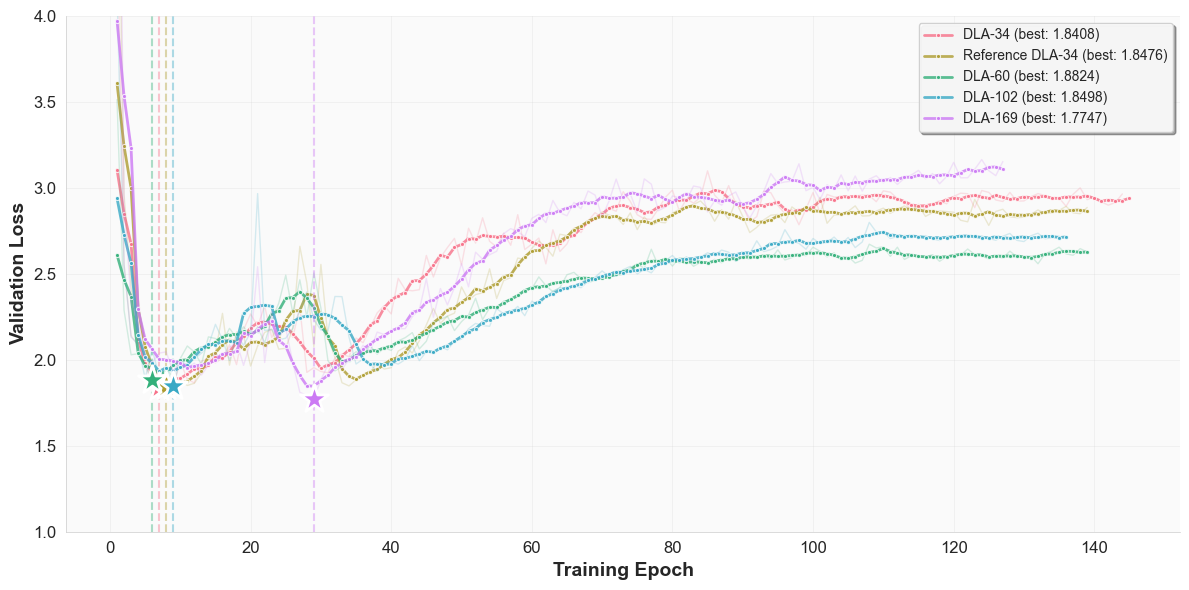

In [121]:
fig, ax = plot_runs(runs_data, x_col='epoch', y_col='val_total_loss',
                    best_values_dict=best_values_dict,
                    title=None,
                    y_min_limit=1.0, y_max_limit=4.0,
                    # title='F1 Score across Training Epochs',
                    xlabel='Training Epoch',
                    ylabel='Validation Loss',
                    filename="model_size_comparison_floreana_s_val_loss_score.pdf")
plt.show()

Run: 20251023_DinoV2L Floreana_p2bzbm16


2025-10-23 21:00:18.053 | INFO     | __main__:plot_runs_dual_metric:167 - Saving plot to Floreana_dinoV2L_loss_comparison.pdf


(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Training vs Validation Loss'}, xlabel='Epoch', ylabel='Loss'>)

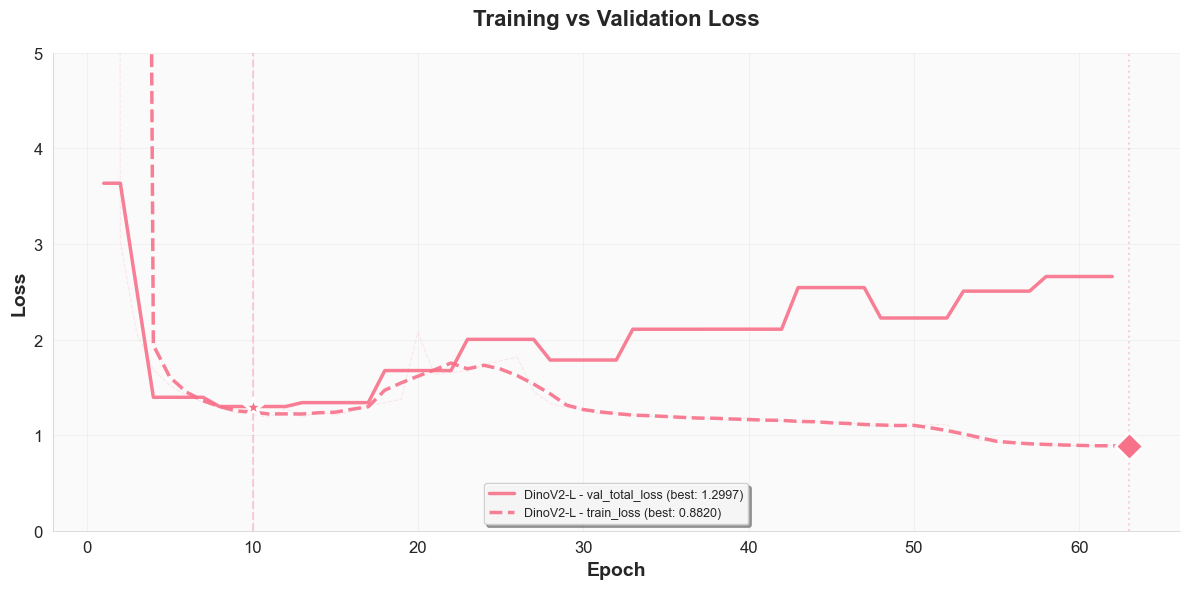

In [135]:
run_1 = api.run("karisu/x13_model_size/6hs4sz8k") # 20251023_DLA-34 Floreana_6hs4sz8k
run_2 = api.run("karisu/x13_model_size/ej0j7ylm") # 20251023_DLA60 Floreana_ej0j7ylm
run_3 = api.run("karisu/x13_model_size/9wbdancd") # 20251023_DLA102 Floreana_9wbdancd
run_4 = api.run("karisu/x13_model_size/xocilxs6") # 20251023_DLA-169 Floreana_xocilxs6
run_5 = api.run("karisu/x13_model_size/w6ghkjdm") # 20251023_reference DLA-34 Floreana_w6ghkjdm
run_6 = api.run("karisu/x13_model_size/p2bzbm16") # 20251023_DinoV2L Floreana_p2bzbm16
# Get best values for both metrics
runs_data = {
    # "DLA-34": get_history(run_1),
    "DinoV2-L": get_history(run_6),
}

best_values_dict = {
    run_name: get_best_values_dual(df, 'epoch', 'val_total_loss', 'train_loss', minimize=True)
    for run_name, df in runs_data.items()
}

best_values_dict

# Plot both val_total_loss and train_loss
plot_runs_dual_metric(
    runs_data,
    x_col='epoch',
    y_col='val_total_loss',
    y_col_2='train_loss',
    best_values_dict=best_values_dict,
    title='Training vs Validation Loss',
    ylabel='Loss',
    smooth=True,
    smooth_window=5,
    filename='Floreana_dinoV2L_loss_comparison.pdf',
    y_max_limit=5
)

## test plot

2025-10-23 20:06:35.768 | INFO     | __main__:plot_runs:160 - Saving plot to floreana_model_size_comparison_f1_score.png


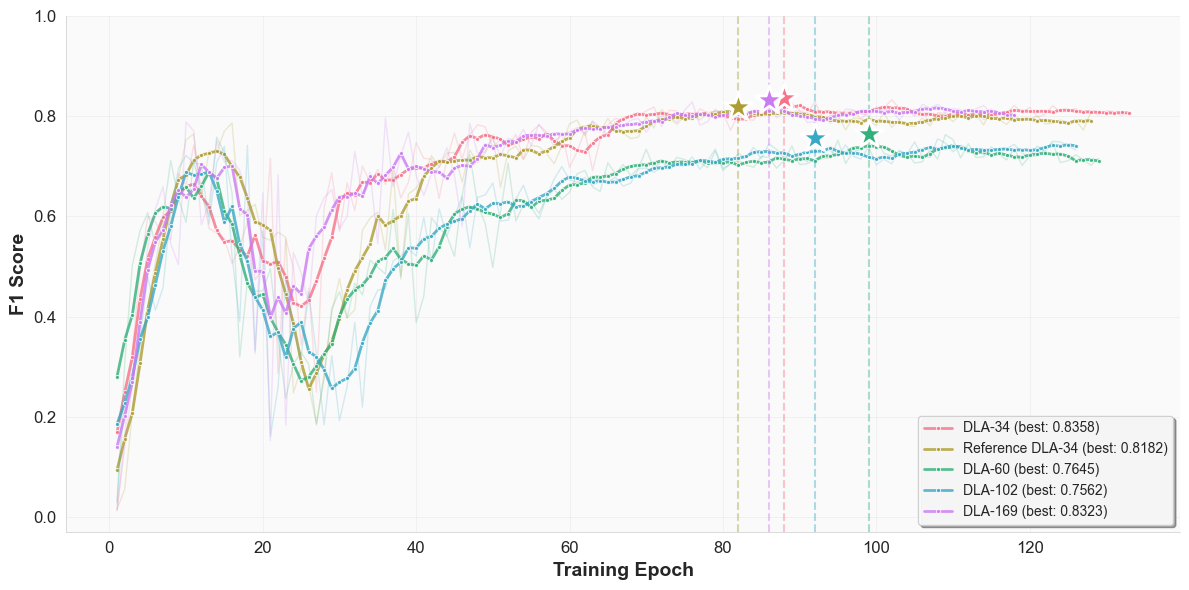

In [100]:
fig, ax = plot_runs(runs_data, x_col='epoch', y_col='f1_score',
                    best_values_dict=best_values,
                    title=None,
                    # title='F1 Score across Training Epochs',
                    xlabel='Training Epoch',
                    ylabel='F1 Score',
                    filename = "floreana_model_size_comparison_f1_score.png")
plt.show()

## Evaluate the effect of learning rate
- 20251023_DLA-34 LR05 Floreana_6c3iyfzc
- 20251023_DLA-34 LR04 Floreana_l32omv1g
- 20251023_DLA-34 LR03 Floreana_6hs4sz8k





## Test for the patch overlap

20251024_DLA-34 LR05 PO160 Floreana_b1mzuumb
20251024_DLA-34 LR05 PO160 Fernandina_vovmyauh

20251024_DLA-34 LR05 PO0 Floreana_v4h5urif
20251024_DLA-34 LR05 PO0 Fernandina_skww3mme





Run: 20251023_x13_model_size_DLA34_fernandina_cvat_corr_dla34_pub_train_tile_eval_tile_aug_default_win7v2oj


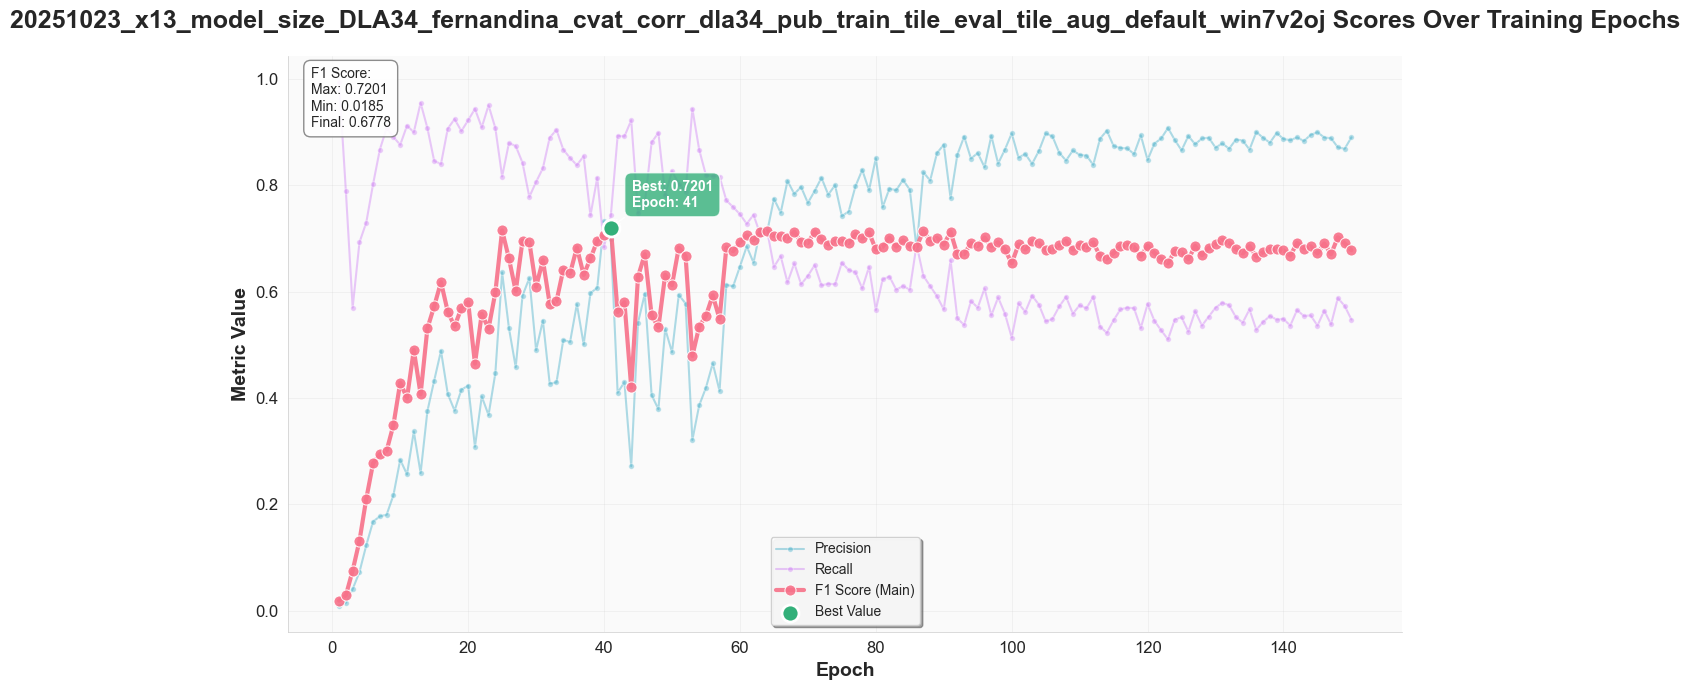

0.7201309328968903


In [101]:
best_run_metric_value = 0
best_run_name = None

metric: str = "f1_score"
run = api.run("karisu/x13_model_size/win7v2oj")
history_df = get_history(run)

plot_metric_over_epochs(history_df,
                        main_metric=metric,
                        aux_metrics=["precision", "recall"],
                        title_suffix=f"{run.name} Scores Over Training Epochs",)

# history_df.to_csv("metrics.csv")
best_epoch = get_best_epoch(history_df, metric=metric)
print(best_epoch[metric])

In [102]:

# Get runs matching filters
runs = wandb.Api().runs(
    path="karisu/x13_model_size", filters={"config.batch_size": 4}
)

for run in runs:
    logger.info(f"Processing run: {run.name}")
    history_df = get_history(run)

    plot_metric_over_epochs(history_df,
                            main_metric=metric,
                            aux_metrics=["precision", "recall"],
                            title_suffix=f"{run.name} Scores Over Training Epochs", )

    # history_df.to_csv("metrics.csv")
    best_epoch = get_best_epoch(history_df, metric=metric)
    print(f"best metrics: {best_epoch[metric]}")

    if best_epoch[metric] > best_run_metric_value:
        best_run_metric_value = best_epoch[metric]
        best_run_name = run.name


print(f"DONE, best run: {best_run_name} with {metric}={best_run_metric_value}")

DONE, best run: None with f1_score=0
